In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('df_training_scholarjet.csv', index_col='cuid').drop('Unnamed: 0', axis='columns')
test = pd.read_csv('df_holdout_scholarjet.csv', index_col='cuid').drop('Unnamed: 0', axis='columns')

# Prep Independent Variables


In [3]:
train = pd.get_dummies(train).reset_index()

In [4]:
# Skew Correction
# NOTE: SKEW CORRECTS REVENUE_30
skewed = train[train.columns[(abs(train.skew()) > 20).values]].skew()
for col in train.columns:
    if col in skewed.index:
        train[col] = np.log1p(train[col])

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


In [5]:
X = train[[col for col in train.columns if col not in ['cuid', 'convert_30', 'revenue_30']]]

In [6]:
# Median fill NaNs
values_impute = {x: X[x].median() for x in X.columns}
X = X.fillna(value = values_impute)

In [7]:
# Drop fully NaN columns
all_nan = X.isna().sum()[X.isna().sum() > 0].index
X = X.drop(all_nan, axis='columns')

# Preliminary Gradient Boosting for Feature Selection


In [8]:
y_convert = train.convert_30

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_convert, test_size=0.20)
model = xgb.XGBClassifier(scale_pos_weight=4)
model.fit(X_train, y_train)
xgb_features = pd.DataFrame(model.feature_importances_, X_train.columns).sort_values(0, ascending=False)


In [10]:
y_pred = model.predict(X_test)
precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test, y_pred)
print("Labels:       0, 1")
print("Precision:  ", precision)
print("Recall:     ", recall)
print("F1:         ", f1)
print("Support:    ", support)
print("Pred Count: ", pd.Series(y_pred).value_counts().values)

Labels:       0, 1
Precision:   [0.9317623  0.36863271]
Recall:      [0.9061379  0.45230263]
F1:          [0.91877147 0.40620384]
Support:     [5018  608]
Pred Count:  [4880  746]


In [11]:
# Select Features
top_20 = xgb_features[:20]
xgb_train = X[top_20.index]
top_20.head()

,0
dayssincelastvisit,0.098599
numtotalpageviewsthirtyseven,0.074126
sumatcprice,0.053753
numskusviewedthirtyseven,0.053286
numatcsixtythirty,0.023818


# Gradient Boosting for Conversion Classification

In [12]:
X_train, X_test, y_train, y_test = train_test_split(xgb_train, y_convert, test_size=0.20)
model = xgb.XGBClassifier(scale_pos_weight=4)
model.fit(X_train, y_train)
xgb_features = pd.DataFrame(model.feature_importances_, X_train.columns).sort_values(0, ascending=False)


In [13]:
y_pred = model.predict(X_test)
precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test, y_pred)
print("Labels:       0, 1")
print("Precision:  ", precision)
print("Recall:     ", recall)
print("F1:         ", f1)
print("Support:    ", support)
print("Pred Count: ", pd.Series(y_pred).value_counts().values)

Labels:       0, 1
Precision:   [0.93478708 0.36862745]
Recall:      [0.90391884 0.47078464]
F1:          [0.91909385 0.41348974]
Support:     [5027  599]
Pred Count:  [4861  765]


# Subset Converted Training Data

In [21]:
index_converted = train[train.convert_30==1].index
X_converted = X.loc[index_converted]
y_revenue = train.loc[index_converted].revenue_30
X_converted.shape, y_revenue.shape

# Feature Selection for Revenue

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_converted, y_revenue, test_size=0.20)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb_revenue_features = pd.DataFrame(model.feature_importances_, X_train.columns).sort_values(0, ascending=False)
 

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 528.6941765350238
Mean Squared Error: 1517024.6941076065
Root Mean Squared Error: 1231.6755636561143


In [28]:
# Select Features
top_20 = xgb_revenue_features[:20]
X_converted = X_converted[top_20.index]

# Gradient Boosting for Revenue Regression

In [29]:
# y_revenue.skew()
# y_revenue = np.log1p(y_revenue)
# y_pred = np.expm1(model.predict(X_test))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_converted, y_revenue, test_size=0.25)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
log_y_pred = model.predict(X_test)

y_pred = np.expm1(log_y_pred)
y_test = np.expm1(y_test)
 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:34:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 530.2510147904026
Mean Squared Error: 1496548.121825154
Root Mean Squared Error: 1223.3348363490488


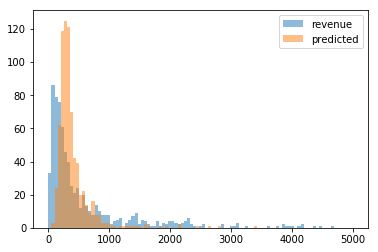

In [42]:
bins = np.linspace(0, 5000, 100)

plt.hist(y_test, bins, alpha=0.5, label='revenue')
plt.hist(y_pred, bins, alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.show()